# RunAge 

> Lucas Santana  
> Laboratory of Biomechanics and Motor Control ([http://demotu.org/](http://demotu.org/))  
> Federal University of ABC, Brazil

Primeiramente, as bibliotecas que foram utilizadas ao decorrer do código para encontrar a potência no tornozelo estão dispostas na linha de código a seguir, principalmente as utilizadas para realizar operações matemáticas e para gerar gráficos.

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, os
from scipy import signal, misc
import scipy.signal
from scipy.integrate import simps

%load_ext autoreload
%autoreload 2
from IPython.display import display, Math, Latex
from mpl_toolkits.mplot3d import Axes3D
# scipy and numpy have too many future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Input

 Para obter os parâmetros dos segmentos perna e pé foram utilizados os valores relacionados à antropometria do sujeito, sendo eles: massa (M) e altura (H). Além disso, foi estabelecido o valor da aceleraão da gravidade (g) de acordo com a norma ISO 80000-3:2006, bem como o quanto o tempo varia em cada frame (dt) de acordo com a frequência de aquisicão dos dados. 

In [2]:
M = 73.1 # Mass (Kg)
H = 1.7430 # Height (m)
g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
dt = 1/150

# Method for finding virtual markers

Para garantir que os sistemas de coordenadas para os segmentos do pé e da perna sejam criados de forma correta, será utilizado o diretório abaixo para criar as marcas virtuais. Não é necessário fazer alterações, visto que foi elaborado de acordo com o Github. 

In [3]:
fileDir = r'./../data'

## Read data

A seguir está o local utilizado para selecionar o sujeito (subj), tentativa realizada por ele (trial) e a plataforma (fplat) corresponde a tentativa. Como em cada tentativa o sujeito pisa de forma corretamente (somente um pé na plataforma) em poucas ou as vezes em 1 ou nenhuma plataforma, o número dela deve ser digitado de forma correta para evitar resultados equivocados. Para tal, substituir todos os números na variável "fplat".

In [4]:
subj = 'WBDS05'
trial = 'walkO02'
fplat = ['Fx1','Fy1','Fz1','COPx1','COPy1','COPz1','Ty1']

Da mesmo forma, os dados referentes ao arquivo contendo os dados estáticos do sujeito serão lidos. Entretanto, neste caso não é necessário que seja realizada quaisquer alterações.

In [5]:
# read column labels
nameS = subj + 'static1.txt'
fnameS = os.path.join(fileDir, nameS)
dfS = pd.read_csv(fnameS, sep='\t', header='infer', skiprows=0, index_col=0, engine='c')
markerLabelsStatic = dfS.columns.tolist()

A seguir estão os arquivos referentes às curvas de potência obtidas no final do código, sobre os sujeitos e tentativas

In [6]:
WBDS01_1 = np.genfromtxt(fname='./../data/dataWBDS01_1.txt', skip_header=1, delimiter = ',')
WBDS01_2 = np.genfromtxt(fname='./../data/dataWBDS01_2.txt', skip_header=1, delimiter = ',')
WBDS01_3 = np.genfromtxt(fname='./../data/dataWBDS01_3.txt', skip_header=1, delimiter = ',')
WBDS05_1 = np.genfromtxt(fname='./../data/dataWBDS05_1.txt', skip_header=1, delimiter = ',')
WBDS05_2 = np.genfromtxt(fname='./../data/dataWBDS05_2.txt', skip_header=1, delimiter = ',')
WBDS05_3 = np.genfromtxt(fname='./../data/dataWBDS05_3.txt', skip_header=1, delimiter = ',')
WBDS34_1 = np.genfromtxt(fname='./../data/dataWBDS34_1.txt', skip_header=1, delimiter = ',')
WBDS34_2 = np.genfromtxt(fname='./../data/dataWBDS34_2.txt', skip_header=1, delimiter = ',')
WBDS34_3 = np.genfromtxt(fname='./../data/dataWBDS34_3.txt', skip_header=1, delimiter = ',')
WBDS36_1 = np.genfromtxt(fname='./../data/dataWBDS36_1.txt', skip_header=1, delimiter = ',')
WBDS36_2 = np.genfromtxt(fname='./../data/dataWBDS36_2.txt', skip_header=1, delimiter = ',')
WBDS36_3 = np.genfromtxt(fname='./../data/dataWBDS36_3.txt', skip_header=1, delimiter = ',')

### Shank markers static

A seguir será realizado os passos referentes à criação dos sistema de coordenadas para a perna, definindo as marcas para este segmento.

In [7]:
shankMarkersS = dfS[['R.HFX', 'R.HFY', 'R.HFZ', 'R.TTX', 'R.TTY', 'R.TTZ',
                     'R.KneeX', 'R.KneeY', 'R.KneeZ',
                     'R.Knee.MedialX', 'R.Knee.MedialY', 'R.Knee.MedialZ',
                     'R.AnkleX', 'R.AnkleY', 'R.AnkleZ','R.Ankle.MedialX', 
                     'R.Ankle.MedialY', 'R.Ankle.MedialZ']]
shankMarkersS = shankMarkersS/1000 # convert to meter
# shank markers
rknl = np.mean(shankMarkersS[['R.KneeX', 'R.KneeY', 'R.KneeZ']].values, axis=0)
rknm = np.mean(shankMarkersS[['R.Knee.MedialX', 'R.Knee.MedialY', 'R.Knee.MedialZ']].values, axis=0)
rhfi = np.mean(shankMarkersS[['R.HFX', 'R.HFY', 'R.HFZ']].values, axis=0)
rtti = np.mean(shankMarkersS[['R.TTX', 'R.TTY', 'R.TTZ']].values, axis=0)
rlml = np.mean(shankMarkersS[['R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values, axis=0)
rmml = np.mean(shankMarkersS[['R.Ankle.MedialX', 'R.Ankle.MedialY', 'R.Ankle.MedialZ']].values, axis=0)
rajc = (rlml+rmml)/2

Com os pontos definidos, abaixo será definido o sistema de coordenadas propriamente dito, utilizando a convenção IOR e CAST

In [8]:
def shankIOR(rhfi,rtti,rlml,rajc):
    """Calculates the shank coordinate system using the convention of IOR and CAST
    """
    # CAST and IOR shank
    xShank = np.cross(rhfi-rajc,rlml-rajc)
    zShank = np.cross(xShank,rtti-rajc)
    yShank = np.cross(zShank,xShank)
    # Normalizing
    xShank = xShank/np.linalg.norm(xShank)
    yShank = yShank/np.linalg.norm(yShank)
    zShank = zShank/np.linalg.norm(zShank)

    shankCAST = np.array([xShank,yShank,zShank])

    return shankCAST

In [9]:
# Shank coordinate system
shankCAST = shankIOR(rhfi,rtti,rlml,rajc)

### Foot markers static

De forma análoga ao que foi realizado para a perna, foram definidas as marcas para o segmento pé.

In [10]:
footMarkersS = dfS[['R.HeelX', 'R.HeelY', 'R.HeelZ', 'R.MT1X', 'R.MT1Y', 'R.MT1Z', 
                    'R.MT2X', 'R.MT2Y', 'R.MT2Z', 'R.MT5X', 'R.MT5Y', 'R.MT5Z']]
footMarkersS = footMarkersS/1000 # convert to meters

# foot markers
rhee = np.mean(footMarkersS[['R.HeelX', 'R.HeelY', 'R.HeelZ']].values, axis=0)
rmt1 = np.mean(footMarkersS[['R.MT1X', 'R.MT1Y', 'R.MT1Z']].values, axis=0)
rmt2 = np.mean(footMarkersS[['R.MT2X', 'R.MT2Y', 'R.MT2Z']].values, axis=0)
rmt5 = np.mean(footMarkersS[['R.MT5X', 'R.MT5Y', 'R.MT5Z']].values, axis=0)

Utilizando a convenção IOR a CAST foi definido o sistema de coordenadas para o pé.

In [11]:
def footIOR(heel,mt1,mt2,mt5):
    """Calculates the foot coordinate system using the convention of IOR and CAST
    """
    # CAST and IOR shank
    yFoot=np.cross(mt5-heel,mt1-heel)
    zFoot=np.cross(mt2-heel,yFoot)
    xFoot=np.cross(yFoot,zFoot)
    # Normalizing
    xFoot=xFoot/np.linalg.norm(xFoot)
    yFoot=yFoot/np.linalg.norm(yFoot)
    zFoot=zFoot/np.linalg.norm(zFoot)

    footIOR = np.array([xFoot,yFoot,zFoot])

    return footIOR

In [12]:
footCSstatic = footIOR(rhee,rmt1,rmt2,rmt5)

### Plot shank coordinate system

De modo a permirir a visualização do sistema de coordenadas e melhorar o entendimento por parte do leitor, foi realizado um plot de ambos os segmentos 

<IPython.core.display.Javascript object>


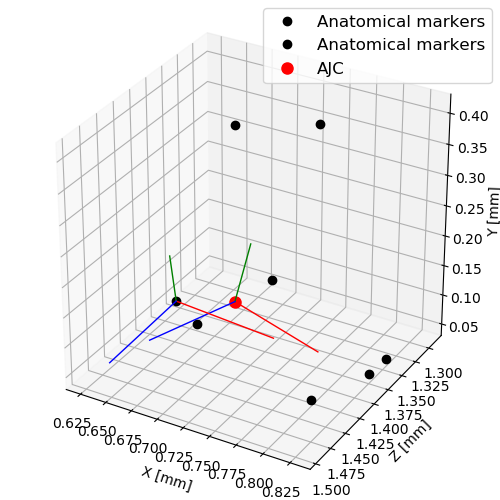

In [13]:
# Plot segment and coordinate system
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1], projection='3d') 
# ax.axis("off")
ngain = 0.1
# Anatomical markers
# Shank
ax.plot([rhee[0],rmt1[0],rmt2[0],rmt5[0]],
        [rhee[2],rmt1[2],rmt2[2],rmt5[2]],
        [rhee[1],rmt1[1],rmt2[1],rmt5[1]],
       'ko',fillstyle='full',label='Anatomical markers')
# Foot
ax.plot([rhfi[0],rtti[0],rlml[0],rmml[0]],
        [rhfi[2],rtti[2],rlml[2],rmml[2]],
        [rhfi[1],rtti[1],rlml[1],rmml[1]],
       'ko',fillstyle='full',label='Anatomical markers')
# Technical markers
# AJC
ax.plot([rajc[0]],[rajc[2]],[rajc[1]],'ro',linewidth = 1,markersize=8,
        fillstyle='full',label='AJC')

# IOR reference frame
# Shank
ax.plot([rajc[0],rajc[0]+shankCAST[0,0]*ngain],[rajc[2],rajc[2]+shankCAST[0,2]*ngain],
        [rajc[1],rajc[1]+shankCAST[0,1]*ngain],linewidth = 1, color = 'red')
ax.plot([rajc[0],rajc[0]+shankCAST[1,0]*ngain],[rajc[2],rajc[2]+shankCAST[1,2]*ngain],
        [rajc[1],rajc[1]+shankCAST[1,1]*ngain],linewidth = 1, color = 'green')
ax.plot([rajc[0],rajc[0]+shankCAST[2,0]*ngain],[rajc[2],rajc[2]+shankCAST[2,2]*ngain],
        [rajc[1],rajc[1]+shankCAST[2,1]*ngain],linewidth = 1, color = 'blue')

# Foot
ax.plot([rhee[0],rhee[0]+footCSstatic[0,0]*ngain],[rhee[2],rhee[2]+footCSstatic[0,2]*ngain],
        [rhee[1],rhee[1]+footCSstatic[0,1]*ngain],linewidth = 1, color = 'red')
ax.plot([rhee[0],rhee[0]+footCSstatic[1,0]*ngain],[rhee[2],rhee[2]+footCSstatic[1,2]*ngain],
        [rhee[1],rhee[1]+footCSstatic[1,1]*ngain],linewidth = 1, color = 'green')
ax.plot([rhee[0],rhee[0]+footCSstatic[2,0]*ngain],[rhee[2],rhee[2]+footCSstatic[2,2]*ngain],
        [rhee[1],rhee[1]+footCSstatic[2,1]*ngain],linewidth = 1, color = 'blue')

ax.axis('equal')
ax.invert_yaxis()
#ax.set_xlim3d(500, 1000)
#ax.set_ylim3d(1000, 1500)
#ax.set_zlim3d(0, 1200)
            
ax.set_xlabel('X [mm]')
ax.set_ylabel('Z [mm]')
ax.set_zlabel('Y [mm]')

ax.legend(frameon=True, loc='best', fontsize=12, numpoints=1)
#ax.view_init
plt.show()

## Read dynamic data files

De modo a ler os arquivos dinâmicos, na linha a seguir o processo é feito de forma automática. Não é necessário a inserção ou modificação de nenhum dado por parte do leitor

In [14]:
# read column labels
nameW = subj + trial + 'Cmkr.txt'
fnameWmkr = os.path.join(fileDir, nameW)
dfW = pd.read_csv(fnameWmkr, sep='\t', header='infer', skiprows=0, index_col=0, engine='c')

### Interpolation

In [15]:
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

In [16]:
markerLabelsWalk = dfW.columns.tolist()

### Downsampling

De modo a garantir que todas as variáveis tenham o mesmo tamanho, será feito nos passos a seguir um "Downsampling" nas variáveis com tamanhos maiores. No caso do banco de dados disponibilizado publicamente, as variáveis contidas no arquivo de forças apresentam comprimentos maiores, necessitando reduzir. Para tal, foi utilizado o comando "signal.decimate".

### Forces

Visando realizar os futuros cálculos de torque e potência, o arquivo de texto contendo as forças foi lido na linha a seguir e inseridos na variável "dfGRF"

In [17]:
# read column labels
nameWgrf = subj + trial + 'Cgrf.txt'
fnameWgrf = os.path.join(fileDir, nameWgrf)
dfGRF = pd.read_csv(fnameWgrf, sep='\t', header='infer', skiprows=0, index_col=0, engine='c')

In [18]:
dfGRF = dfGRF[fplat]
grfLabelsWalk = dfGRF.columns.tolist()
grf = dfGRF[fplat].values

for igrf, grfLabel in enumerate(grfLabelsWalk):
    dfW[grfLabel] = signal.decimate(dfGRF[grfLabel], 2)

In [19]:
dfGRF = dfW
labelList = dfGRF.columns.tolist()

### Low-pass Butterworth filter

Para filtrar os dados das marcas, foi utilizado um filtro Butterworth:

In [20]:
freq = 150
# Butterworth filter
b, a = butter(2, (10/(freq/2)))
for col,mkrLabel in enumerate(labelList):
    dfGRF[mkrLabel] = filtfilt(b, a, dfGRF[mkrLabel])

### Static and Dynamic markers

Foram lidas todas as marcas (dos arquivos estático e dos arquivos referentes ao andar) da perna. Posteriormente, todas marcas de ambos os arquivos foram convertidas para metros, respeitando o SI.

In [21]:
shankMarkersstatic = dfS[['R.HFX', 'R.HFY', 'R.HFZ', 'R.TTX', 'R.TTY', 'R.TTZ', 
                     'R.KneeX', 'R.KneeY', 'R.KneeZ','R.AnkleX', 'R.AnkleY', 'R.AnkleZ']]
shankMarkerswalk = dfGRF[['R.HFX', 'R.HFY', 'R.HFZ', 'R.TTX', 'R.TTY', 'R.TTZ', 
                     'R.KneeX', 'R.KneeY', 'R.KneeZ', 'R.AnkleX', 'R.AnkleY', 'R.AnkleZ']]

# Convert to meters
shankMarkersstatic = shankMarkersstatic/1000
shankMarkerswalk = shankMarkerswalk/1000

De forma análoga ao que foi feito anteriormente, o mesmo procedimento foi realizado para o segmento pé, tanto a leitura dos arquivos quanto a conversão para metros.

In [22]:
footMarkersstatic = dfS[['R.HeelX', 'R.HeelY', 'R.HeelZ', 'R.MT1X', 'R.MT1Y', 'R.MT1Z', 
                    'R.MT5X', 'R.MT5Y', 'R.MT5Z']]
footMarkerswalk = dfGRF[['R.HeelX', 'R.HeelY', 'R.HeelZ', 'R.MT1X', 'R.MT1Y', 'R.MT1Z', 
                    'R.MT5X', 'R.MT5Y', 'R.MT5Z']]

# Convert to meters
footMarkersstatic = footMarkersstatic/1000
footMarkerswalk = footMarkerswalk/1000

### Transform anatomical markers

Para realizar a transformação entre dois sistemas de coordenadas, foram determimadas a matrix de rotação, bem como o vetor de translação. Para tal, foram utilizadas as funções "svdt" e "svd", ambas disponíveis em [1].

In [23]:
def svdt(A, B, order='col'):
    """Calculates the transformation between two coordinate systems using SVD.
    This function determines the rotation matrix (R) and the translation vector
    (L) for a rigid body after the following transformation [1]_, [2]_:
    B = R*A + L + err.
    Where A and B represents the rigid body in different instants and err is an
    aleatory noise (which should be zero for a perfect rigid body). A and B are
    matrices with the marker coordinates at different instants (at least three
    non-collinear markers are necessary to determine the 3D transformation).
    The matrix A can be thought to represent a local coordinate system (but A
    it's not a basis) and matrix B the global coordinate system. The operation
    Pg = R*Pl + L calculates the coordinates of the point Pl (expressed in the
    local coordinate system) in the global coordinate system (Pg).
    A typical use of the svdt function is to calculate the transformation
    between A and B (B = R*A + L), where A is the matrix with the markers data
    in one instant (the calibration or static trial) and B is the matrix with
    the markers data for one or more instants (the dynamic trial).
    If the parameter order='row', the A and B parameters should have the shape
    (n, 3), i.e., n rows and 3 columns, where n is the number of markers.
    If order='col', A can be a 1D array with the shape (n*3, like
    [x1, y1, z1, ..., xn, yn, zn] and B a 1D array with the same structure of A
    or a 2D array with the shape (ni, n*3) where ni is the number of instants.
    The output R has the shape (ni, 3, 3), L has the shape (ni, 3), and RMSE
    has the shape (ni,). If ni is equal to one, the outputs will have the
    singleton dimension dropped.
    Part of this code is based on the programs written by Alberto Leardini,
    Christoph Reinschmidt, and Ton van den Bogert.
    Parameters
    ----------
    A   : Numpy array
        Coordinates [x,y,z] of at least three markers with two possible shapes:
        order='row': 2D array (n, 3), where n is the number of markers.
        order='col': 1D array (3*nmarkers,) like [x1, y1, z1, ..., xn, yn, zn].
    B   : 2D Numpy array
        Coordinates [x,y,z] of at least three markers with two possible shapes:
        order='row': 2D array (n, 3), where n is the number of markers.
        order='col': 2D array (ni, n*3), where ni is the number of instants.
        If ni=1, B is a 1D array like A.
    order : string
        'col': specifies that A and B are column oriented (default).
        'row': specifies that A and B are row oriented.
    Returns
    -------
    R   : Numpy array
        Rotation matrix between A and B with two possible shapes:
        order='row': (3, 3).
        order='col': (ni, 3, 3), where ni is the number of instants.
        If ni=1, R will have the singleton dimension dropped.
    L   : Numpy array
        Translation vector between A and B with two possible shapes:
        order='row': (3,) if order = 'row'.
        order='col': (ni, 3), where ni is the number of instants.
        If ni=1, L will have the singleton dimension dropped.
    RMSE : array
        Root-mean-squared error for the rigid body model: B = R*A + L + err
        with two possible shapes:
        order='row': (1,).
        order='col': (ni,), where ni is the number of instants.
    See Also
    --------
    numpy.linalg.svd
    Notes
    -----
    The singular value decomposition (SVD) algorithm decomposes a matrix M
    (which represents a general transformation between two coordinate systems)
    into three simple transformations [3]_: a rotation Vt, a scaling factor S
    along the  rotated axes and a second rotation U: M = U*S*Vt.
    The rotation matrix is given by: R = U*Vt.
    References
    ----------
    .. [1] Soderkvist, Kedin (1993) Journal of Biomechanics, 26, 1473-1477.
    .. [2] http://www.kwon3d.com/theory/jkinem/rotmat.html.
    .. [3] http://en.wikipedia.org/wiki/Singular_value_decomposition.
    Examples
    --------
    >>> import numpy as np
    >>> from svdt import svdt
    >>> A = np.array([0,0,0, 1,0,0,  0,1,0,  1,1,0])  # four markers
    >>> B = np.array([0,0,0, 0,1,0, -1,0,0, -1,1,0])  # four markers
    >>> R, L, RMSE = svdt(A, B)
    >>> B = np.vstack((B, B))  # simulate two instants (two rows)
    >>> R, L, RMSE = svdt(A, B)
    >>> A = np.array([[0,0,0], [1,0,0], [ 0,1,0], [ 1,1,0]])  # four markers
    >>> B = np.array([[0,0,0], [0,1,0], [-1,0,0], [-1,1,0]])  # four markers
    >>> R, L, RMSE = svdt(A, B, order='row')
    """

    A, B = np.asarray(A), np.asarray(B)
    if order == 'row' or B.ndim == 1:
        if B.ndim == 1:
            A = A.reshape(int(A.size/3), 3)
            B = B.reshape(int(B.size/3), 3)
        R, L, RMSE = svd(A, B)
    else:
        A = A.reshape(int(A.size/3), 3)
        ni = B.shape[0]
        R = np.empty((ni, 3, 3))
        L = np.empty((ni, 3))
        RMSE = np.empty(ni)
        for i in range(ni):
            R[i, :, :], L[i, :], RMSE[i] = svd(A, B[i, :].reshape(A.shape))

    return R, L, RMSE

In [24]:
def svd(A, B):
    """Calculates the transformation between two coordinate systems using SVD.
    See the help of the svdt function.
    Parameters
    ----------
    A   : 2D Numpy array (n, 3), where n is the number of markers.
        Coordinates [x,y,z] of at least three markers
    B   : 2D Numpy array (n, 3), where n is the number of markers.
        Coordinates [x,y,z] of at least three markers
    Returns
    -------
    R    : 2D Numpy array (3, 3)
         Rotation matrix between A and B
    L    : 1D Numpy array (3,)
         Translation vector between A and B
    RMSE : float
         Root-mean-squared error for the rigid body model: B = R*A + L + err.
    See Also
    --------
    numpy.linalg.svd
    """

    Am = np.mean(A, axis=0)           # centroid of m1
    Bm = np.mean(B, axis=0)           # centroid of m2
    M = np.dot((B - Bm).T, (A - Am))  # considering only rotation
    # singular value decomposition
    U, S, Vt = np.linalg.svd(M)
    # rotation matrix
    R = np.dot(U, np.dot(np.diag([1, 1, np.linalg.det(np.dot(U, Vt))]), Vt))
    # translation vector
    L = B.mean(0)  - np.dot(R, A.mean(0))
    # RMSE
    err = 0
    for i in range(A.shape[0]):
        Bp = np.dot(R, A[i, :]) + L
        err += np.sum((Bp - B[i, :])**2)
    RMSE = np.sqrt(err/A.shape[0]/3)

    return R, L, RMSE

Agora será calculado a matrix de rotação e de translação, com o auxílio das duas funções acima.

In [25]:
# Calculating the translation and rotation matrix
# from svdt import svdt
Rshank, Lshank, RMSE = svdt(shankMarkersstatic.values.mean(axis=0), shankMarkerswalk.values)
Rfoot, Lfoot, RMSE = svdt(footMarkersstatic.values.mean(axis=0), footMarkerswalk.values)

Com o auxílio das matrizes obtidas, foram definidas as marcas da perna.

In [26]:
# shank markers
rknlw = shankMarkerswalk[['R.KneeX', 'R.KneeY', 'R.KneeZ']].values
rknmw = np.dot(Rshank,rknm) + Lshank
rhfiw = shankMarkerswalk[['R.HFX', 'R.HFY', 'R.HFZ']].values
rttiw = shankMarkerswalk[['R.TTX', 'R.TTY', 'R.TTZ']].values
rlmlw = shankMarkerswalk[['R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values
rmmlw = np.dot(Rshank,rmml) + Lshank
rkjcw = (rknlw+rknmw)/2
rajcw = (rlmlw+rmmlw)/2

De forma análoga ao que foi feito para o segmento perna, foram definidas as marcas para o pé.

In [27]:
# foot markers
rheew = footMarkerswalk[['R.HeelX', 'R.HeelY', 'R.HeelZ']].values
rmt1w = footMarkerswalk[['R.MT1X', 'R.MT1Y', 'R.MT1Z']].values
rmt2w = np.dot(Rfoot,rmt2) + Lfoot
rmt5w = footMarkerswalk[['R.MT5X', 'R.MT5Y', 'R.MT5Z']].values

## Segment reference system during walking

Como ambos os segmentos se movimentam, mudando de posição durante o andar, foram definidos os sistemas de coordenadas que acompanham essa mudança de posição.

In [28]:
shankCSwalk= np.empty(shape=(len(rheew),3,3))
footCSwalk = np.empty(shape=(len(rheew),3,3))
for ix in range(rheew.shape[0]):
    shankCSwalk[ix,:,:] = shankIOR(rhfiw[ix,:],rttiw[ix,:],rlmlw[ix,:],rajcw[ix,:])
    footCSwalk[ix,:,:]  = footIOR(rheew[ix,:],rmt1w[ix,:],rmt2w[ix,:],rmt5w[ix,:])

#### Markers positions

A nomenclatura utilizada anteriormente para as marcas foi substituída pela utilizada por Leardini et al. [2]

In [29]:
LM = rlmlw
MM = rmmlw
VM = rmt5w
FM = rmt1w
CA = rheew
HF = rhfiw
TT = rttiw

## Basis

De modo a satidfazer de forma eficaz esse sistema de coordenadas, foram criadas bases em cada um dos segmentos (respeitando a ocnvenção IOR) e definidos agora os 3 versores de cada base, tanto da perna quanto do pé.

#### Foot

In [30]:
e3_foot = footCSwalk[:,2,:]
e2_foot = footCSwalk[:,1,:]
e1_foot = footCSwalk[:,0,:]

#### Shank

In [31]:
e3_shank = shankCSwalk[:,2,:]
e2_shank = shankCSwalk[:,1,:]
e1_shank = shankCSwalk[:,0,:]

## Angular acceleration

Os versores são extremamente importantes para o cálculo da aceleração angular dos segmentos. Para tal, todos foram derivados ("dedt_foot" e "dedt_shank") e em seguida multiplicados pelos valores dos outros segmentos, gerando desse modo a aceleração angular ("omega_foot" e "omega_shank")

#### Foot

In [32]:
de1dt_foot = (e1_foot[2:,:]-e1_foot[0:-2,:])/(2*dt)
de2dt_foot = (e2_foot[2:,:]-e2_foot[0:-2,:])/(2*dt)
de3dt_foot = (e3_foot[2:,:]-e3_foot[0:-2,:])/(2*dt)

omega_footFoot = np.hstack((np.sum(de2dt_foot*e3_foot[1:-1,:], axis = 1).reshape(-1,1), 
                        np.sum(de3dt_foot*e1_foot[1:-1,:], axis = 1).reshape(-1,1), 
                        np.sum(de1dt_foot*e2_foot[1:-1,:], axis = 1).reshape(-1,1)))
omega_footFoot = np.vstack((omega_footFoot, omega_footFoot[-1, :], omega_footFoot[-1, :]))

A aceleração angular obtida acima foi gerada na coordenada local do pé. De modo a evitar erros nos futuros cálculos, foi criada uma matriz de rotação e a aceleração angular foi obtida na coordenada global do laboratório.

In [33]:
omega_footGlobal = np.zeros_like(omega_footFoot)
for i in range(omega_footFoot.shape[0]):
    RGLomega_foot = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    omega_footGlobal[i,:]=RGLomega_foot.T@omega_footFoot[i,:] #A transposta faz com que seja da coordenada local p/ global


#### Shank

In [34]:
de1dt_shank = (e1_shank[2:,:]-e1_shank[0:-2,:])/(2*dt)
de2dt_shank = (e2_shank[2:,:]-e2_shank[0:-2,:])/(2*dt)
de3dt_shank = (e3_shank[2:,:]-e3_shank[0:-2,:])/(2*dt)

omega_shankShank = np.hstack((np.sum(de2dt_shank*e3_shank[1:-1,:], axis = 1).reshape(-1,1), 
                         np.sum(de3dt_shank*e1_shank[1:-1,:], axis = 1).reshape(-1,1), 
                         np.sum(de1dt_shank*e2_shank[1:-1,:], axis = 1).reshape(-1,1)))
omega_shankShank = np.vstack((omega_shankShank, omega_shankShank[-1, :], omega_shankShank[-1, :]))

Utilizando o mesmo pensamento, a velocidade angular do pé também foi obtida na coordenada global do laboratório.

In [35]:
omega_shankGlobal = np.zeros_like(omega_shankShank)
for i in range(omega_shankShank.shape[0]):
    RGLomega_shank = np.vstack((e1_shank[i,:],e2_shank[i,:],e3_shank[i,:]))
    omega_shankGlobal[i,:]=RGLomega_shank.T@omega_shankShank[i,:] #A transposta faz com que seja da coordenada local p/ global

## Center of mass

Creating a plane:

In [36]:
a = HF - LM
b = LM - MM
n = np.cross(a, b, axis=1)
n_norm = n/np.linalg.norm(n, axis=1, keepdims=True)

Finding the distance between TT and the TTp:

In [37]:
d = np.sum((TT-LM)*n_norm,axis=1, keepdims=True)
TTp = TT - (d*n_norm)

Testing (Must be zero):

In [38]:
Test =np.sum((HF - TTp)*n_norm, axis=1)
Test

array([ 1.38777878e-17, -3.46944695e-18, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17,  1.04083409e-17, -1.38777878e-17,  1.38777878e-17,
       -6.93889390e-18, -6.93889390e-18, -1.04083409e-17,  1.04083409e-17,
        1.73472348e-17,  0.00000000e+00,  1.38777878e-17, -6.93889390e-18,
        1.04083409e-17, -2.77555756e-17,  3.46944695e-17,  6.93889390e-18,
       -2.42861287e-17,  1.38777878e-17,  1.04083409e-17, -4.51028104e-17,
        1.73472348e-17, -2.08166817e-17,  1.38777878e-17, -3.46944695e-18,
        2.42861287e-17, -1.04083409e-17, -3.46944695e-18,  3.46944695e-18,
       -2.08166817e-17, -2.42861287e-17, -3.46944695e-18, -6.93889390e-18,
       -3.46944695e-18,  3.46944695e-18,  3.46944695e-18, -6.93889390e-18,
        0.00000000e+00, -1.73472348e-17, -1.38777878e-17,  1.04083409e-17,
        3.46944695e-18, -3.46944695e-18,  6.93889390e-18, -1.04083409e-17,
        2.08166817e-17, -3.46944695e-18,  1.73472348e-17, -6.93889390e-18,
       -2.08166817e-17,  

Segments positions:

In [39]:
r_foot_prox = CA
r_foot_dis = (VM+FM)/2
r_shank_prox = TTp
r_shank_dis =(MM+LM)/2

The position of the center of mass of each segment:

In [40]:
# BSP male values from Zatsiorsky's model adjusted by de Leva (1996)
rcm_foot  = r_foot_prox + 0.4415*(r_foot_dis-r_foot_prox)
rcm_shank  = r_shank_prox + 0.4395*(r_shank_dis-r_shank_prox)

The velocity of the center of mass of each segment:

In [41]:
vcm_foot = (rcm_foot[2:,:]-rcm_foot[0:-2,:])/(2*dt)
vcm_foot = np.vstack((vcm_foot, vcm_foot[-1, :], vcm_foot[-1, :]))
vcm_shank = (rcm_shank[2:,:]-rcm_shank[0:-2,:])/(2*dt)
vcm_shank = np.vstack((vcm_shank, vcm_shank[-1, :], vcm_shank[-1, :]))

The acceleration of the center of mass of each segment:

In [42]:
acm_foot = (vcm_foot[2:,:]-vcm_foot[0:-2,:])/(2*dt)
acm_foot = np.vstack((acm_foot, acm_foot[-1, :], acm_foot[-1, :]))
acm_shank = (vcm_shank[2:,:]-vcm_shank[0:-2,:])/(2*dt)
acm_shank = np.vstack((acm_shank, acm_shank[-1, :], acm_shank[-1, :]))

## Displacement of the COP with respect to the UD segment’s COM

Para calcular a potência pelo método proposto por Takahashi et al., foi necessário obter a distância do centro de pressão até o centro de massa da componente rígida, que no caso é o segmento perna.

In [43]:
cop_position = dfGRF[['COPx1','COPy1','COPz1']].values/1000
rUD_cop_aux = cop_position - rcm_shank
rUD_cop = rUD_cop_aux[0:len(omega_shankGlobal)]              

## Total deformation velocity of the distal component

Como a potência é o produto da força pela velocidade (ou torque pela velocidade angular), foi obtida a velocidade de translação do segmento UD, que utiliza o centro de massa da perna, sua velocidade angular e a distância entre o centro de pressão e o centro de massa da perna.

In [44]:
VUDd = vcm_shank + np.cross(omega_shankGlobal, rUD_cop)

## Total distal power of the UD segment

A potência total do segmento UD é a soma da "potência de trsnalação" com  a "potência de rotação", onde ess última utiliza o momento livre e a velocidade angular da perna

In [45]:
aux6 = dfGRF['Ty1'].values/1000
aux7 = (len(aux6),3)
aux7  = np.zeros(aux7 )
aux7 [:,1] = aux6
Mfree = aux7 

Fgrf = dfGRF[['Fx1','Fy1','Fz1']].values

In [46]:
aux4 = np.sum(Fgrf[0:len(VUDd)]*VUDd, axis=1)
aux5 = np.sum(Mfree[0:len(omega_shankGlobal)]*omega_shankGlobal, axis=1)
PUD = aux4 + aux5

<IPython.core.display.Javascript object>


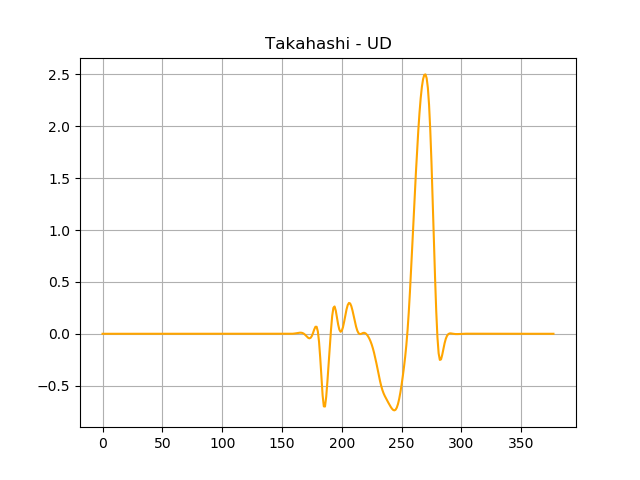

In [47]:
plt.figure()
plt.title('Takahashi - UD')
plt.plot(PUD/M, color = 'orange')
plt.show()
plt.grid()

## Inverse dynamics

Para realizar o cálculo das forças e torques por meio da dinâmica inversa, alguns parâmetros são necessários. Todos estes parâmetros estão dispostos a seguir:

#### Segment mass

Partindo do princípio de que a massa de cada segmento do corpo é uma porcentagem da massa total do sujeito, as massas do pé e da perna foram obtidas por valores tabelados da literatura.

In [48]:
# BSP male values from Zatsiorsky's model adjusted by de Leva (1996)
m_foot = M*0.0137
m_shank = M*0.0433

#### Moment of inertia of the segments

Da mesma que as massas, foram utilizados valores tabelados para se obter o momento de inércia nos planos sagital, longitudinal e transversal. Esse procedimento foi repetido para ambos os segmentos, respeitando os valores tabelados da literatura.

In [49]:
# BSP male values from Zatsiorsky's model adjusted by de Leva (1996)
I1_foot = m_foot*((0.257*(np.mean(np.linalg.norm(r_foot_dis-r_foot_prox, axis=1)))**2)) #Sag 
I2_foot = m_foot*((0.124*(np.mean(np.linalg.norm(r_foot_dis-r_foot_prox, axis=1)))**2))#Long 
I3_foot = m_foot*((0.245*(np.mean(np.linalg.norm(r_foot_dis-r_foot_prox, axis=1)))**2))#Trans
I1_shank = m_shank*((0.251*(np.mean(np.linalg.norm(r_shank_dis-r_shank_prox, axis=1)))**2))#Sag
I2_shank = m_shank*((0.102*(np.mean(np.linalg.norm(r_shank_dis-r_shank_prox, axis=1)))**2))#Long
I3_shank = m_shank*((0.246*(np.mean(np.linalg.norm(r_shank_dis-r_shank_prox, axis=1)))**2))#Trans

#### Segments angular acceleration

As velocidades angulares e cada segmento obtidas anteriormente foram derivadas para se obter as acelerações angulares

In [50]:
alpha_footGlobal = (omega_footGlobal[2:,:]-omega_footGlobal[0:-2,:])/(2*dt) #Global
alpha_footGlobal = np.vstack((alpha_footGlobal, alpha_footGlobal[-1, :], alpha_footGlobal[-1, :]))
alpha_shankGlobal = (omega_shankGlobal[2:,:]-omega_shankGlobal[0:-2,:])/(2*dt) #Global
alpha_shankGlobal = np.vstack((alpha_shankGlobal, alpha_shankGlobal[-1, :], alpha_shankGlobal[-1, :]))

### Forces

Iniciando do segmento pé, foi realizado a soma das forças em ambos os segmentos. As forças provenientes de outro segmento foram adotadas como tendo sinal negativo, comopode ser visualizado nas equaqções de força para a perna, onde "F_ankle" teve o final negativo.

##### Foot

In [51]:
g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
Fgrf = Fgrf[0:len(acm_foot)]

Fx_foot = m_foot*acm_foot[:,0] - Fgrf[:,0]
Fy_foot = m_foot*acm_foot[:,1] - Fgrf[:,1]
Fz_foot = m_foot*acm_foot[:,2] - Fgrf[:,2] + m_foot*g 
F_ankle=np.hstack((Fx_foot.reshape(-1,1),Fy_foot.reshape(-1,1),Fz_foot.reshape(-1,1)))

##### Shank

In [52]:
Fx_shank = m_shank*acm_shank[:,0] + F_ankle[:,0]
Fy_shank = m_shank*acm_shank[:,1] + F_ankle[:,1] 
Fz_shank = m_shank*acm_shank[:,2] + F_ankle[:,2] + m_shank*g
F_knee=np.hstack((Fx_shank.reshape(-1,1),Fy_shank.reshape(-1,1),Fz_shank.reshape(-1,1)))

### Moments

Para garantir que as equações dos torques fossem feitas na coordenada correta, as acelerações angulares do pé e da perna, assim como o momento livre receberam uma matrix de rotação para a base local.

In [53]:
#Foot
alpha_footFoot = np.zeros_like(alpha_footGlobal)
for i in range(alpha_footGlobal.shape[0]):
    RLGalpha_foot = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    alpha_footFoot[i,:]=RLGalpha_foot@alpha_footGlobal[i,:]
    

#Shank
alpha_shankShank = np.zeros_like(alpha_shankGlobal)
for i in range(alpha_shankGlobal.shape[0]):
    RLGalpha_shank = np.vstack((e1_shank[i,:],e2_shank[i,:],e3_shank[i,:]))
    alpha_shankShank[i,:]=RLGalpha_shank@alpha_shankGlobal[i,:]

#Free Moment
MfreeFoot = np.zeros_like(Mfree)
for i in range(Mfree.shape[0]):
    RLGMfree = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    MfreeFoot[i,:]=RLGMfree@Mfree[i,:]

##### Foot

Com as matrizes de rptação criadas, foram computados 2 dos 3 torques no segmento pé. O primeiro deles foi o torque referente ao produto vetorial da distância do tornozelo até o centro de massa pela força no tornozelo (MF_anklefootGlobal). O segundo foi o torque referente ao produto vetorial da distância do centro de pressão até o centro de pressão pela força de reação do solo (MF_grfGlobal). Ambos os torques estavam na coordenada global, e também foram obtidos para a coordenada local por meio de uma matriz de rotação (MF_anklefootFoot e MF_grfFoot).

In [54]:
# M_ankle = "I*alpha" - (rp -rcm) X Força no tornozeo - (rd - rcm) X força de reação do solo - Momento livre
MF_anklefootGlobal = np.cross(r_shank_dis[0:len(F_ankle)] - rcm_foot[0:len(F_ankle)], F_ankle)
MF_grfGlobal = np.cross(cop_position[0:len(Fgrf)] - rcm_foot[0:len(Fgrf)], Fgrf)

# Rotation matrix to the local basis
MF_grfFoot = np.zeros_like(MF_grfGlobal)
MF_anklefootFoot = np.zeros_like(MF_grfGlobal)
for i in range(MF_grfGlobal.shape[0]):
    RLGMF_grf = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    MF_grfFoot[i,:]=RLGMF_grf@MF_grfGlobal[i,:]
    MF_anklefootFoot[i,:]=RLGMF_grf@MF_anklefootGlobal[i,:]

Para obter o torque no tornozelo, foi utilizada a segunda lei Newton-Euler, que fez uso também do momento livre e do momento de inércia do pé, obtido anteriormente.

<IPython.core.display.Javascript object>


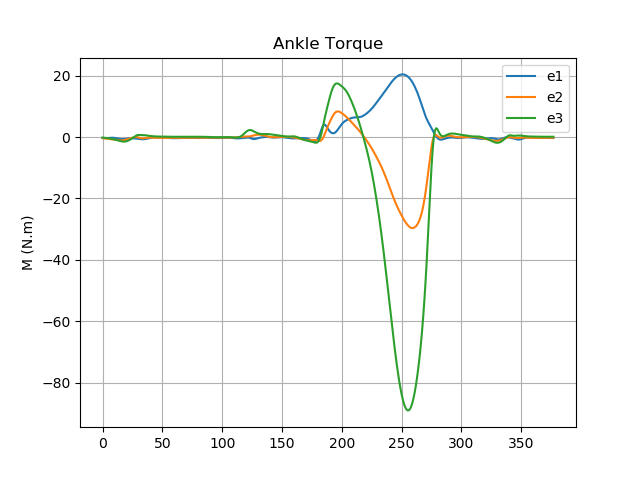

<IPython.core.display.Javascript object>


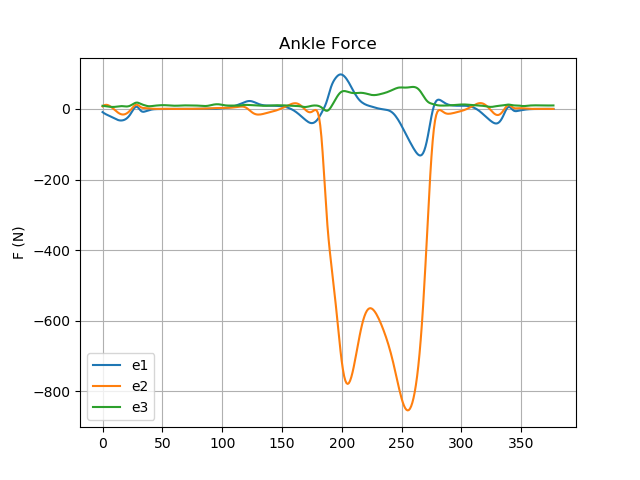

In [55]:
# M_ankle = "I*alpha" - (rp -rcm) X Força no tornozeo - (rd - rcm) X força de reação do solo - Momento livre
I_foot = np.array([[I1_foot,0,0],[0,I2_foot,0],[0,0,I3_foot]])
M_ankleFoot = (I_foot@alpha_footFoot.T).T  + np.cross(omega_footFoot[0:alpha_footFoot.shape[0],:], (I_foot@omega_footFoot[0:alpha_footFoot.shape[0],:].T).T,axis=1) - MF_anklefootFoot - MF_grfFoot - MfreeFoot[0:len(MF_anklefootFoot)]

plt.figure()
plt.plot(M_ankleFoot)
plt.legend(('e1','e2','e3'))
plt.title('Ankle Torque')
plt.ylabel('M (N.m)')
plt.grid()

plt.figure()
plt.plot(F_ankle)
plt.title('Ankle Force')
plt.legend(('e1','e2','e3'))
plt.ylabel('F (N)')
plt.grid()
plt.show()

#### Shank

Computing the moments:

In [56]:
# M_knee = "I*alpha" + M_ankle + (rd -rcm) X Força do tornozelo - (rp - rcm) X Forças na perna
MF_kneeshankGlobal = np.cross(r_shank_prox[0:len(F_knee)] - rcm_shank[0:len(F_knee)], F_knee) #from shank
MF_ankleshankGlobal = np.cross(r_shank_dis[0:len(F_ankle)] - rcm_shank[0:len(F_ankle)], F_ankle)   #from foot

# Rotation matrix to the local basis
MF_kneeshankShank = np.zeros_like(MF_ankleshankGlobal)
MF_ankleshankShank = np.zeros_like(MF_ankleshankGlobal)
M_ankleShank = np.zeros_like(M_ankleFoot)

for i in range(MF_ankleshankGlobal.shape[0]):
    RLGMF_ankle = np.vstack((e1_shank[i,:],e2_shank[i,:],e3_shank[i,:]))
    RLGMF_foot = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    MF_kneeshankShank[i,:]=RLGMF_ankle@MF_kneeshankGlobal[i,:]
    MF_ankleshankShank[i,:]=RLGMF_ankle@MF_ankleshankGlobal[i,:]
    M_ankleShank[i,:] = RLGMF_ankle@RLGMF_foot.T@M_ankleFoot[i,:]

Second Newton-Euler law to obtain the knee moment:

<IPython.core.display.Javascript object>


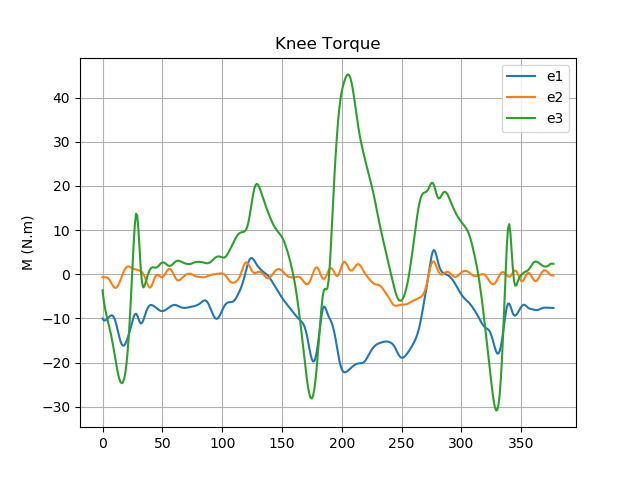

<IPython.core.display.Javascript object>


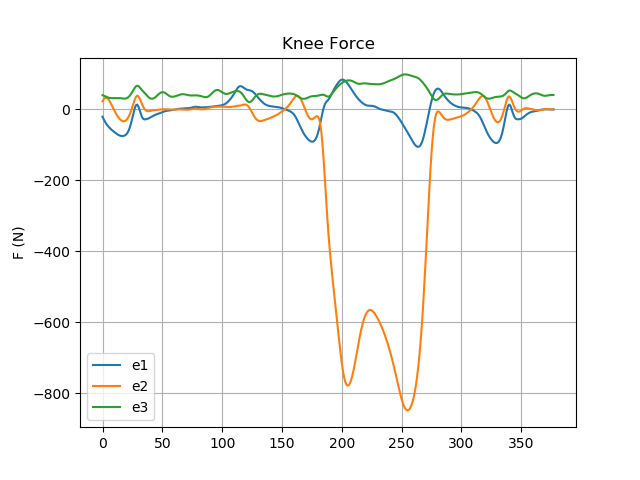

In [57]:
# M_knee = "I*alpha" + M_knee + (rd -rcm) X Força do tornozelo - (rp - rcm) X Forças na perna
I_shank = np.array([[I1_shank,0,0],[0,I2_shank,0],[0,0,I3_shank]])
M_kneeShank = (I_shank@alpha_shankShank.T).T  + np.cross(omega_shankShank[0:alpha_shankShank.shape[0],:], (I_shank@omega_shankShank[0:alpha_shankShank.shape[0],:].T).T,axis=1) - MF_kneeshankShank + MF_ankleshankShank + M_ankleShank

plt.figure()
plt.plot(M_kneeShank)
plt.legend(('e1','e2','e3'))
plt.title('Knee Torque')
plt.ylabel('M (N.m)')
plt.grid()

plt.figure()
plt.plot(F_knee)
plt.title('Knee Force')
plt.legend(('e1','e2','e3'))
plt.ylabel('F (N)')
plt.grid()
plt.show()

## Anatomically-relevant (AR) Power

A forma mais completa de se obter a potência por meio da dinâmica inversa é pela soma da potência do tornozelo obtida com um modelo de 6 graus de liberdade com a potência no pé.

#### Angular Velocity

Para obter a velocidade angular no tornozelo, foi feita a subtração da velocidade angular no pé pela velocidade angular na perna

In [58]:
omega_ankleGlobal = omega_footGlobal - omega_shankGlobal

#### Transforming to the global basis

Da mesma forma que foi feito nos passos anteriores, o torque no tornozelo foi transformado para a coordenada global do laboratório

In [59]:
#M_ankleFoot
M_ankleGlobal = np.zeros_like(M_ankleFoot)
for i in range(M_ankleFoot.shape[0]):
    RGLM_ankle = np.vstack((e1_foot[i,:],e2_foot[i,:],e3_foot[i,:]))
    M_ankleGlobal[i,:]=RGLM_ankle.T@M_ankleFoot[i,:]

#### Joint Velocity

Com a velocidade de rotação obtida, no passo seguinte foi feita a equação para obter a velocidade de translação no tornozelo. Para tal, foram calculadas as velocidades no tornozelo referentes a cada um dos segmentos. Em seguida, ambas as velocidade foram subtraídas para obter a velocidade na articulação do tornozelo.

In [60]:
VcopGlobal = vcm_foot + np.cross(omega_footGlobal, cop_position[0:len(omega_footGlobal)] - rcm_foot[0:len(omega_footGlobal)])
VanklefootGlobal = vcm_foot + np.cross(omega_footGlobal, r_shank_dis[0:len(omega_footGlobal)] - rcm_foot[0:len(omega_footGlobal)])
VankleshankGlobal = vcm_shank + np.cross(omega_shankGlobal, r_shank_dis[0:len(omega_shankGlobal)] - rcm_shank[0:len(omega_shankGlobal)])
deltaVGlobal = VanklefootGlobal - VankleshankGlobal

#### Power (Pank)

A potência no tornozelo foi obtida utilizando os modelo de 6 graus de liberdade para os cálculos, somando a potência de translação com a potência de rotação

In [61]:
Pank = np.sum(M_ankleGlobal[0:len(Fgrf)]*omega_ankleGlobal[0:len(Fgrf)], axis=1) + np.sum(F_ankle[0:len(Fgrf)]*deltaVGlobal[0:len(Fgrf)], axis=1)

#### Power (Pftd)

A potência no pé foi obtida pela soma dos produtos entre a forla de reação do solo com a velocidade do centro de pressão com o produto do momento livre com a velocidade angular.

In [62]:
Pftd = np.sum(Fgrf*VcopGlobal[0:len(Fgrf)], axis=1) + np.sum(Mfree[0:len(Fgrf)]*omega_footGlobal[0:len(Fgrf)], axis=1)

#### Power (PAR)

Ambas as potências obtidas anteriormente foram somadas para se obter a potência total

In [63]:
Par = Pank + Pftd

<IPython.core.display.Javascript object>


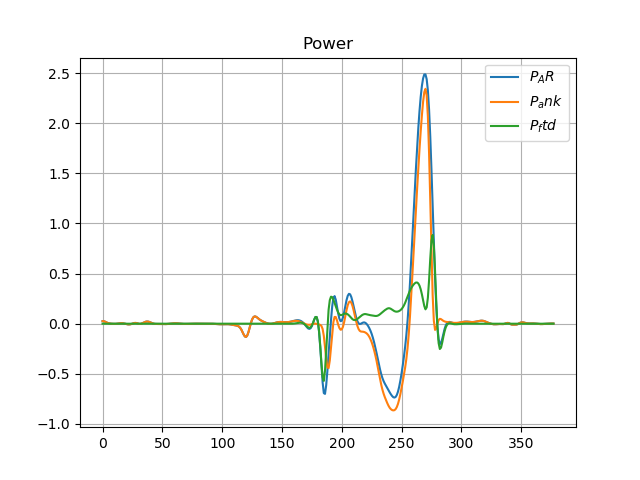

In [64]:
plt.figure()
plt.plot(Par/M)
plt.plot(Pank/M)
plt.plot(Pftd/M)
plt.legend(('$P_AR$','$P_ank$','$P_ftd$'))
plt.title(('Power'))
plt.show()
plt.grid()

<IPython.core.display.Javascript object>


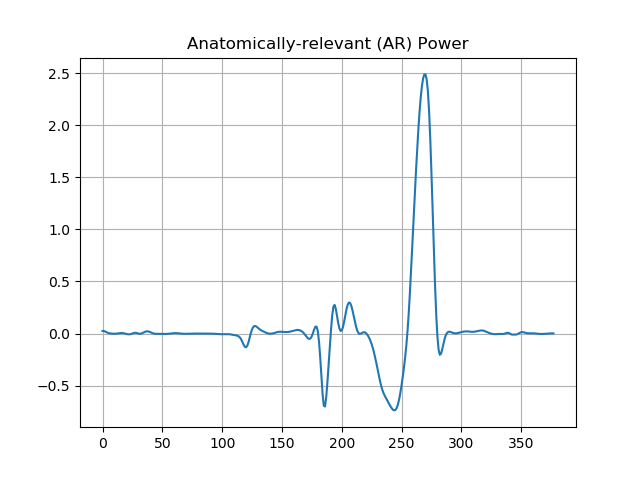

In [65]:
plt.figure()
plt.plot(Par/M)
plt.title(('Anatomically-relevant (AR) Power'))
plt.show()
plt.grid()

## Zelik Method

De modo a comparar os diferentes métodos para se obter a potência, após o método UD e pela dinâmica inversa o próximo a ser estudado é o modelo proposto por Zelik et al., onde para o cálculo da velocidade de translação tambpem foi utilizado um vetor que representa a distância do centro de pressão até o centro de massa da perna (semelhante ao UD)

<IPython.core.display.Javascript object>


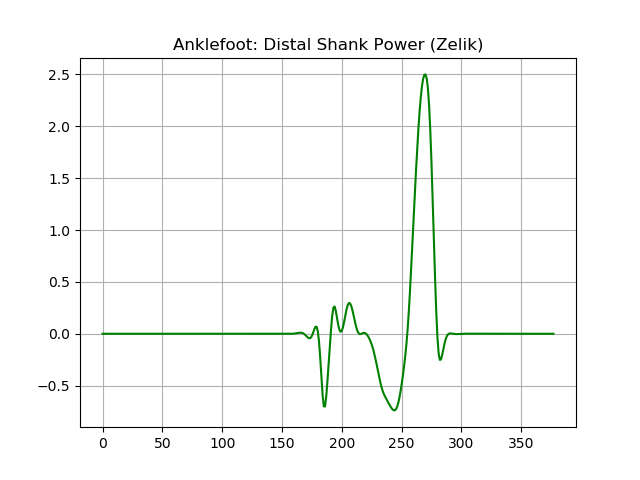

In [66]:
# Pdistal_shank_zelik = Fgrf.(Vcm_shank + omega_shank X r_cop/shank) + Mfree.omega_shank

rcp_shank_zelik = cop_position - rcm_shank
Mshank_zelik = vcm_shank + np.cross(omega_shankGlobal, rcp_shank_zelik[0:len(vcm_shank)])
Pdistal_shank_zelik = np.sum(Fgrf*Mshank_zelik[0:len(Fgrf)], axis=1) + np.sum(Mfree[0:len(Fgrf)]*omega_shankGlobal[0:len(Fgrf)], axis = 1)

plt.figure()
plt.plot(Pdistal_shank_zelik/M, color = 'green')
plt.title(('Anklefoot: Distal Shank Power (Zelik)'))
plt.show()
plt.grid()

# The Distal Shank Method (DS) - Frigo

Este método é semelhante ao anterior,com a única diferença de que o ponto da perna escolhido pode ser qualquer um. Esse fato é possível pq comoa perna é um corpo rígido a equação é válida para qualquer ponto deste corpo. Este trabalho resolveu adotar o ponto escolhido como o centro de massa da perna.

<IPython.core.display.Javascript object>


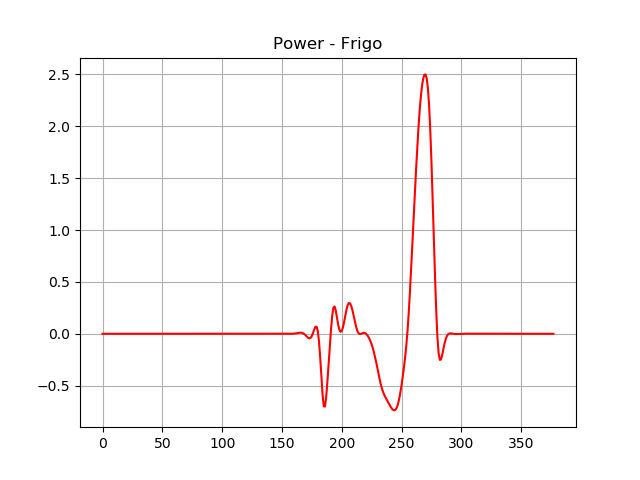

In [67]:
# Pdistal_shank_frigo = Fgrf.Vcm_sahnk + (Mgrf/shank + Mfree).Omega_shank
Mgrf_shank = np.cross(rUD_cop[0:len(Fgrf)], Fgrf)
Pdistal_shank_frigo = np.sum(Fgrf*vcm_shank[0:len(Fgrf)], axis=1) + np.sum((Mgrf_shank + Mfree[0:len(Fgrf)])*omega_shankGlobal[0:len(Fgrf)], axis=1)

plt.figure()
plt.plot(Pdistal_shank_frigo/M, color = 'red')
plt.title(('Power - Frigo'))
plt.show()
plt.grid()

De modo a facilitar o entendimento do leitor, agora será apresentado um comparativo entre todas as potências calculadas até agora.

<IPython.core.display.Javascript object>


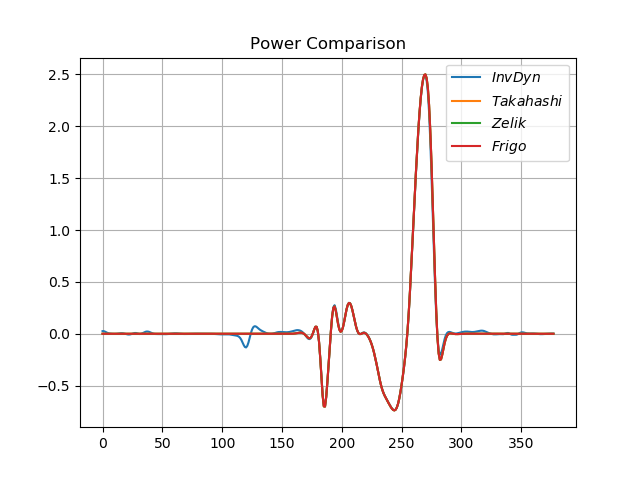

In [68]:
plt.figure()
plt.plot(Par/M)
plt.plot(PUD/M)
plt.plot(Pdistal_shank_zelik/M)
plt.plot(Pdistal_shank_frigo/M)
plt.title(('Power Comparison'))
plt.legend(('$InvDyn$','$Takahashi$','$Zelik$', '$Frigo$'))
plt.show()
plt.grid()

# Lower extremity distal power analysis


Com os métodos definidos, o próximo passo foi realizar um ocmparativo entre sujeitos jovens e idosos, e como as potências se comportam em cada um deles. Nessa análise inicial, foram utilizados 4 sujeitos (2 jovens e 2 idosos), onde cada possui 3 arquivos de dados.

In [69]:
def detect_onset(x, threshold=0, n_above=1, n_below=0,
                 threshold2=None, n_above2=1, show=False, ax=None):
    """Detects onset in data based on amplitude threshold.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : number, optional (default = 0)
        minimum amplitude of `x` to detect.
    n_above : number, optional (default = 1)
        minimum number of continuous samples >= `threshold`
        to detect (but see the parameter `n_below`).
    n_below : number, optional (default = 0)
        minimum number of continuous samples below `threshold` that
        will be ignored in the detection of `x` >= `threshold`.
    threshold2 : number or None, optional (default = None)
        minimum amplitude of `n_above2` values in `x` to detect.
    n_above2 : number, optional (default = 1)
        minimum number of samples >= `threshold2` to detect.
    show  : bool, optional (default = False)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    inds : 2D array_like [indi, indf]
        initial and final indeces of the onset events.

    Notes
    -----
    You might have to tune the parameters according to the signal-to-noise
    characteristic of the data.

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectOnset.ipynb

    Examples
    --------
    >>> from detect_onset import detect_onset
    >>> x = np.random.randn(200)/10
    >>> x[51:151] += np.hstack((np.linspace(0,1,50), np.linspace(1,0,50)))
    >>> detect_onset(x, np.std(x[:50]), n_above=10, n_below=0, show=True)

    >>> x = np.random.randn(200)/10
    >>> x[51:151] += np.hstack((np.linspace(0,1,50), np.linspace(1,0,50)))
    >>> x[80:140:20] = 0
    >>> detect_onset(x, np.std(x[:50]), n_above=10, n_below=0, show=True)

    >>> x = np.random.randn(200)/10
    >>> x[51:151] += np.hstack((np.linspace(0,1,50), np.linspace(1,0,50)))
    >>> x[80:140:20] = 0
    >>> detect_onset(x, np.std(x[:50]), n_above=10, n_below=2, show=True)

    >>> x = [0, 0, 2, 0, np.nan, 0, 2, 3, 3, 0, 1, 1, 0]
    >>> detect_onset(x, threshold=1, n_above=1, n_below=0, show=True)

    >>> x = np.random.randn(200)/10
    >>> x[11:41] = np.ones(30)*.3
    >>> x[51:151] += np.hstack((np.linspace(0,1,50), np.linspace(1,0,50)))
    >>> x[80:140:20] = 0
    >>> detect_onset(x, .1, n_above=10, n_below=1, show=True)

    >>> x = np.random.randn(200)/10
    >>> x[11:41] = np.ones(30)*.3
    >>> x[51:151] += np.hstack((np.linspace(0,1,50), np.linspace(1,0,50)))
    >>> x[80:140:20] = 0
    >>> detect_onset(x, .4, n_above=10, n_below=1, show=True)

    >>> x = np.random.randn(200)/10
    >>> x[11:41] = np.ones(30)*.3
    >>> x[51:151] += np.hstack((np.linspace(0,1,50), np.linspace(1,0,50)))
    >>> x[80:140:20] = 0
    >>> detect_onset(x, .1, n_above=10, n_below=1,
                     threshold2=.4, n_above2=5, show=True)

    Version history
    ---------------
    '1.0.6':
        Deleted 'from __future__ import'
        added parameters `threshold2` and `n_above2`
    """

    x = np.atleast_1d(x).astype('float64')
    # deal with NaN's (by definition, NaN's are not greater than threshold)
    x[np.isnan(x)] = -np.inf
    # indices of data greater than or equal to threshold
    inds = np.nonzero(x >= threshold)[0]
    if inds.size:
        # initial and final indexes of almost continuous data
        inds = np.vstack((inds[np.diff(np.hstack((-np.inf, inds))) > n_below+1], \
                          inds[np.diff(np.hstack((inds, np.inf))) > n_below+1])).T
        # indexes of almost continuous data longer than or equal to n_above
        inds = inds[inds[:, 1]-inds[:, 0] >= n_above-1, :]
        # minimum amplitude of n_above2 values in x to detect
        if threshold2 is not None and inds.size:
            idel = np.ones(inds.shape[0], dtype=bool)
            for i in range(inds.shape[0]):
                if np.count_nonzero(x[inds[i, 0]: inds[i, 1]+1] >= threshold2) < n_above2:
                    idel[i] = False
            inds = inds[idel, :]
    if not inds.size:
        inds = np.array([])  # standardize inds shape for output
    if show and x.size > 1:  # don't waste my time ploting one datum
        _plot(x, threshold, n_above, n_below, threshold2, n_above2, inds, ax)

    return inds


def _plot(x, threshold, n_above, n_below, threshold2, n_above2, inds, ax):
    """Plot results of the detect_onset function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        if inds.size:
            for (indi, indf) in inds:
                if indi == indf:
                    ax.plot(indf, x[indf], 'ro', mec='r', ms=6)
                else:
                    ax.plot(range(indi, indf+1), x[indi:indf+1], 'r', lw=1)
                    ax.axvline(x=indi, color='b', lw=1, ls='--')
                ax.axvline(x=indf, color='b', lw=1, ls='--')
            inds = np.vstack((np.hstack((0, inds[:, 1])),
                              np.hstack((inds[:, 0], x.size-1)))).T
            for (indi, indf) in inds:
                ax.plot(range(indi, indf+1), x[indi:indf+1], 'k', lw=1)
        else:
            ax.plot(x, 'k', lw=1)
            ax.axhline(y=threshold, color='r', lw=1, ls='-')

        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        if threshold2 is not None:
            text = 'threshold=%.3g, n_above=%d, n_below=%d, threshold2=%.3g, n_above2=%d'
        else:
            text = 'threshold=%.3g, n_above=%d, n_below=%d, threshold2=%r, n_above2=%d'            
        ax.set_title(text % (threshold, n_above, n_below, threshold2, n_above2))
        # plt.grid()
        plt.show()

## Read data

As variáveis "methods" e "methods2" representam os arquivos para as potências nos 4 métodos e para as 3 potências obtidas durante o cálculo da dinâmica inversa.

In [70]:
methods = ['# InvDyn', 'Takahashi', 'Zelik', 'Frigo']
methods2 = ['# Pank', 'Pftd', 'Par']

## Young subjects

A primeira parte dessa linha de código está realizando a média das potências usando os 4 métodos para os jovens. A segunda faz o mesmo, mas para as potências obtidas pelo cálculo da dinâmica inversa.

In [71]:
# Young
subjects = ['01','05']
yn3 = np.empty(shape=(101,4))
for im, method in enumerate(methods):
    yn2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        yn = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'dataWBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            yn[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        yn2[:,s] = np.nanmean(yn, axis=1)
        
    # Average across subjects
    yn3[:,im] = np.nanmean(yn2, axis=1)
    
# Young
subjects = ['01','05']
ynp3 = np.empty(shape=(101,4))
for im, method in enumerate(methods2):
    ynp2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        ynp = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'data2WBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            ynp[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        ynp2[:,s] = np.nanmean(ynp, axis=1)
        
    # Average across subjects
    ynp3[:,im] = np.nanmean(ynp2, axis=1)

## Older subjects

A primeira parte dessa linha de código está realizando a média das potências usando os 4 métodos para os idosos. A segunda faz o mesmo, mas para as potências obtidas pelo cálculo da dinâmica inversa.

In [72]:
# Older
subjects = ['34','36']
on3 = np.empty(shape=(101,4))
for im, method in enumerate(methods):
    on2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        on = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'dataWBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            on[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        on2[:,s] = np.nanmean(on, axis=1)
        
    # Average across subjects
    on3[:,im] = np.nanmean(on2, axis=1)
    
# Older
subjects = ['34','36']
onp3 = np.empty(shape=(101,4))
for im, method in enumerate(methods2):
    onp2 = np.empty(shape=(101,len(subjects)))
    for s in range(len(subjects)):
        onp = np.empty(shape=(101,3))
        for trial in range(3):
            # read column labels
            nameS = 'data2WBDS' + subjects[s] + '_' + str(trial+1) + '.txt'
            fnameS = os.path.join(fileDir, nameS)
            dfS = pd.read_csv(fnameS, sep=',', header=0, skiprows=0, index_col=None, engine='c')
            
            # Detect events
            inds = detect_onset(dfS['GRF'], 20, n_above=10, n_below=0, show=False)
            
            xx = dfS[method].values[inds[0][0]:inds[0][1]]
            
            t  = np.linspace(0, 100, len(xx))  # time vector for the original data
            tn = np.linspace(0, 100, 101)     # new time vector for the new time-normalized data
            onp[:,trial] = np.interp(tn, t, xx)
        
        # Average across trials
        onp2[:,s] = np.nanmean(onp, axis=1)
        
    # Average across subjects
    onp3[:,im] = np.nanmean(onp2, axis=1)

# Compare methods and groups

In [73]:
methods = ['# InvDyn', 'Takahashi', 'Zelik', 'Frigo']

A primeira comparação a ser feita foi entre as potências dos 4 métodos, onde o gráfico de cima representa os jovens e o de baixo as potências nos idosos.

<IPython.core.display.Javascript object>


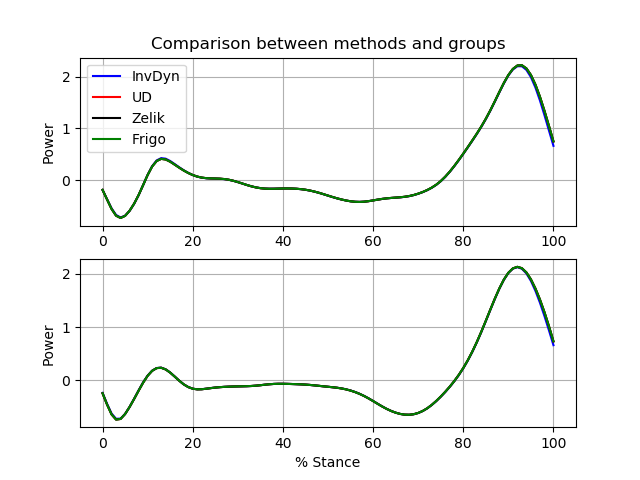

In [74]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(yn3[:,0],'b-', label='InvDyn')
plt.plot(yn3[:,1],'r-', label='UD')
plt.plot(yn3[:,2],'k-', label='Zelik')
plt.plot(yn3[:,3],'g-', label='Frigo')
plt.title('Comparison between methods and groups')
plt.ylabel('Power')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(on3[:,0],'b-', label='InvDyn')
plt.plot(on3[:,1],'r-', label='UD')
plt.plot(on3[:,2],'k-', label='Zelik')
plt.plot(on3[:,3],'g-', label='Frigo')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()

De forma análoga ao que foi feito no gráfico anterior, o gráfico seguinte apresenta uma comparação entre as três potências oriundas da dinâmica inversa, no qual o gráfico de cima representas as potências nos jovens e o de baixo as potências nos idosos.

<IPython.core.display.Javascript object>


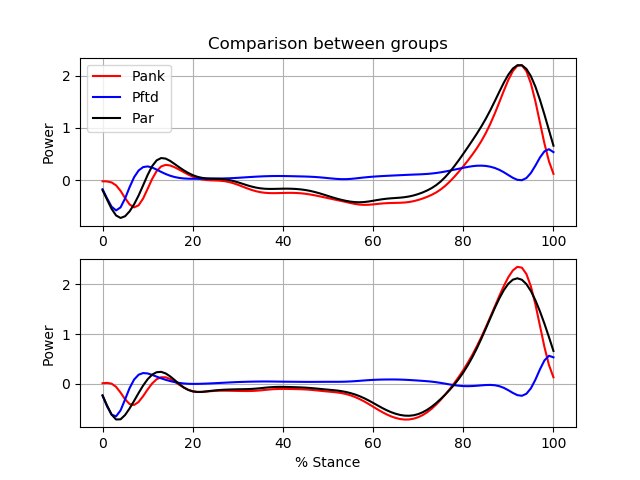

In [75]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(ynp3[:,0],'r-', label='Pank')
plt.plot(ynp3[:,1],'b-', label='Pftd')
plt.plot(ynp3[:,2],'k-', label='Par')
plt.title('Comparison between groups')
plt.ylabel('Power')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(onp3[:,0],'r-', label='Pank')
plt.plot(onp3[:,1],'b-', label='Pftd')
plt.plot(onp3[:,2],'k-', label='Par')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()

## Young vs Older comparison

Essa segunda parte da análise é focada na comparação entre jovens e idosos com uma maior ênfase. O gráfico a seguir compara as potências entre os dois grupos, onde no gráfico de cima foi utilizado a dinâmica inversa e no gráfico abaixo um dos métodos que consideram o pé como rígido.

<IPython.core.display.Javascript object>


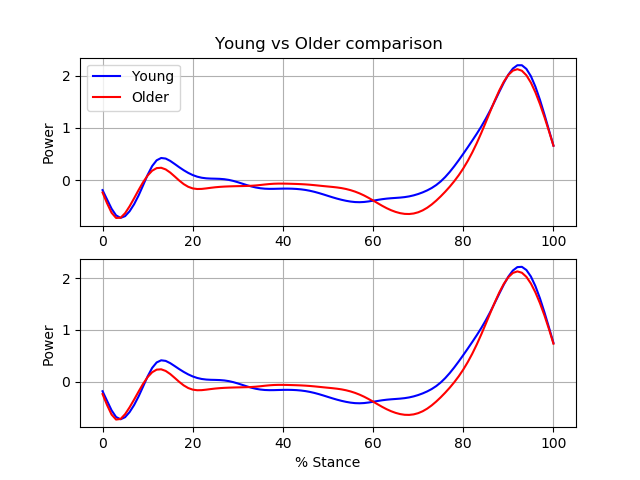

In [76]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(yn3[:,0],'b-', label='Young')
plt.plot(on3[:,0],'r-', label='Older')
plt.title('Young vs Older comparison')
plt.ylabel('Power')
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.plot(yn3[:,3],'b-', label='Young')
plt.plot(on3[:,3],'r-', label='Older')
plt.ylabel('Power')
plt.xlabel('% Stance')
plt.grid()
plt.show()

# Peak ankle joint powers

Após a apresentação visual dos resultados preliminares, nos passos a seguir estão dispostos os resultados de forma numérica. O primeiro resultado apresentado é a potência de pico. A potência de pico foi separada entre negativa e positiva, entre jovens e idosos e entre os 4 métodos.  

In [77]:
# Inverse Dynamics
#positive
max_invdyn_young = np.around(np.max(yn3[:,0]),3)
max_invdyn_older = np.around(np.max(on3[:,0]),3)
#negative
min_invdyn_young = np.around(np.min(yn3[:,0]),3)
min_invdyn_older = np.around(np.min(on3[:,0]),3)

# Takahashi
#positive
max_takahashi_young = np.around(np.max(yn3[:,1]),3)
max_takahashi_older = np.around(np.max(on3[:,1]),3)
#negative
min_takahashi_young = np.around(np.min(yn3[:,1]),3)
min_takahashi_older = np.around(np.min(on3[:,1]),3)

# Zelik
#positive
max_zelik_young = np.around(np.max(yn3[:,2]),3)
max_zelik_older = np.around(np.max(on3[:,2]),3)
#negative
min_zelik_young = np.around(np.min(yn3[:,2]),3)
min_zelik_older = np.around(np.min(on3[:,2]),3)

# Frigo
#positive
max_frigo_young = np.around(np.max(yn3[:,3]),3)
max_frigo_older = np.around(np.max(on3[:,3]),3)
#negative
min_frigo_young = np.around(np.min(yn3[:,3]),3)
min_frigo_older = np.around(np.min(on3[:,3]),3)

print('\033[1m' + "Positive peak anle power - Inverse Dynamics:\n")
print('\033[0m' + "Young: ", max_invdyn_young,"W/kg")
print('\033[0m' + "Older: ", max_invdyn_older,"W/kg")
print('\033[1m' + "\nNegative peak anle power - Inverse Dynamics:\n")
print('\033[0m' + "Young: ", min_invdyn_young,"W/kg")
print('\033[0m' + "Older: ", min_invdyn_older,"W/kg")
print('\033[1m' + "\nPositive peak anle power - Takahashi:\n")
print('\033[0m' + "Young: ", max_takahashi_young,"W/kg")
print('\033[0m' + "Older: ", max_takahashi_older,"W/kg")
print('\033[1m' + "\nNegative peak anle power - Takahashi:\n")
print('\033[0m' + "Young: ", min_takahashi_young,"W/kg")
print('\033[0m' + "Older: ", min_takahashi_older,"W/kg")
print('\033[1m' + "\nPositive peak anle power - Zelik:\n")
print('\033[0m' + "Young: ", max_zelik_young,"W/kg")
print('\033[0m' + "Older: ", max_zelik_older,"W/kg")
print('\033[1m' + "\nNegative peak anle power - Zelik:\n")
print('\033[0m' + "Young: ", min_zelik_young,"W/kg")
print('\033[0m' + "Older: ", min_zelik_older,"W/kg")
print('\033[1m' + "\nPositive peak anle power - Frigo:\n")
print('\033[0m' + "Young: ", max_frigo_young,"W/kg")
print('\033[0m' + "Older: ", max_frigo_older,"W/kg")
print('\033[1m' + "\nNegative peak anle power - Frigo:\n")
print('\033[0m' + "Young: ", min_frigo_young,"W/kg")
print('\033[0m' + "Older: ", min_frigo_older,"W/kg")

Positive peak anle power - Inverse Dynamics:

Young:  2.198 W/kg
Older:  2.123 W/kg

Negative peak anle power - Inverse Dynamics:

Young:  -0.72 W/kg
Older:  -0.721 W/kg

Positive peak anle power - Takahashi:

Young:  2.218 W/kg
Older:  2.129 W/kg

Negative peak anle power - Takahashi:

Young:  -0.73 W/kg
Older:  -0.735 W/kg

Positive peak anle power - Zelik:

Young:  2.218 W/kg
Older:  2.129 W/kg

Negative peak anle power - Zelik:

Young:  -0.73 W/kg
Older:  -0.735 W/kg

Positive peak anle power - Frigo:

Young:  2.218 W/kg
Older:  2.129 W/kg

Negative peak anle power - Frigo:

Young:  -0.73 W/kg
Older:  -0.735 W/kg


# Area under the curve (Work)

O segundo resultado apresentado é o trabalho. Antes do cálculo prorpiamente dito, foram definidas duas funções: uma para o cálculo do trabalho positivo (positive_trapz) e uma segunda para o cálculo do trabalho negativo (negative_trapz).

In [78]:
#Only positive power
def positive_trapz(y, x=None, dx=1.0):
    y = np.asanyarray(y)
    if x is None:
        d = dx
    else:
        x = np.asanyarray(x)
        d = np.diff(x)
    ret = (d * (y[1:] +y[:-1]) / 2.0)
    return ret[ret>0].sum()  

# Only negative work
def negative_trapz(y, x=None, dx=1.0):
    y = np.asanyarray(y)
    if x is None:
        d = dx
    else:
        x = np.asanyarray(x)
        d = np.diff(x)
    ret = (d * (y[1:] +y[:-1]) / 2.0)
    return ret[ret<0].sum()  

## Young subjects

Com as duas funções definidas, foram realizados os cálculos dos trabalhos para os sujeitos jovens, em que foram divididos pelos 4 métodos estudados. Deve-se ressaltar que ao salvar os dados de potência da dinâmica inversa em formato texto, o Python gerou um símbolo neste termo (# InvDyn).

In [79]:
subjects = ['01','05']
methods = ['# InvDyn', 'Takahashi', 'Zelik', 'Frigo']
positive = np.empty(shape=(3,))
negative = np.empty(shape=(3,))
posM = np.empty(shape=(2,))
negM = np.empty(shape=(2,))
for im, method in enumerate(methods):
    for isb, subject in enumerate(subjects):
        for trial in range(3):
            xvar = eval('WBDS' + subject + '_' + str(trial+1))            
            pos = np.around(positive_trapz(xvar[:,im], dx = 1/150),3)
            neg = np.around(negative_trapz(xvar[:,im], dx = 1/150),3)
                        
            
            positive[trial] = pos
            negative[trial] = neg
    
        posM[isb] = np.mean(positive, axis=0)
        negM[isb] = np.mean(negative, axis=0)
        
    posM2 = np.mean(posM, axis=0)
    negM2 = np.mean(negM, axis=0)
   
    
    print('Trabalho positivo ' + method + ' = ' + str(np.around(posM2,3)) + ' J')
    print('Trabalho negativo ' + method + ' = ' + str(np.around(negM2,3)) + ' J\n')  

Trabalho positivo # InvDyn = 0.253 J
Trabalho negativo # InvDyn = -0.128 J

Trabalho positivo Takahashi = 0.241 J
Trabalho negativo Takahashi = -0.12 J

Trabalho positivo Zelik = 0.241 J
Trabalho negativo Zelik = -0.12 J

Trabalho positivo Frigo = 0.241 J
Trabalho negativo Frigo = -0.12 J



## Older subjects

Por mim, o mesmo procedimento foi realizado para o cálculo da potência para ambos os sujeitos idosos, também sendo separados por métodos.

In [80]:
subjects = ['34','36']
methods = ['# InvDyn', 'Takahashi', 'Zelik', 'Frigo']
positive = np.empty(shape=(3,))
negative = np.empty(shape=(3,))
posM = np.empty(shape=(2,))
negM = np.empty(shape=(2,))
for im, method in enumerate(methods):
    for isb, subject in enumerate(subjects):
        for trial in range(3):
            xvar = eval('WBDS' + subject + '_' + str(trial+1))            
            pos = np.around(positive_trapz(xvar[:,im], dx = 1/150),3)
            neg = np.around(negative_trapz(xvar[:,im], dx = 1/150),3)
                        
            
            positive[trial] = pos
            negative[trial] = neg
    
        posM[isb] = np.mean(positive, axis=0)
        negM[isb] = np.mean(negative, axis=0)
        
    posM2 = np.mean(posM, axis=0)
    negM2 = np.mean(negM, axis=0)
   
    
    print('Trabalho positivo ' + method + ' = ' + str(np.around(posM2,3)) + ' J')
    print('Trabalho negativo ' + method + ' = ' + str(np.around(negM2,3)) + ' J\n') 

Trabalho positivo # InvDyn = 0.234 J
Trabalho negativo # InvDyn = -0.152 J

Trabalho positivo Takahashi = 0.224 J
Trabalho negativo Takahashi = -0.146 J

Trabalho positivo Zelik = 0.224 J
Trabalho negativo Zelik = -0.146 J

Trabalho positivo Frigo = 0.224 J
Trabalho negativo Frigo = -0.146 J



## References

[1] Duarte, M. (2015) Notes on Scientific Computing for Biomechanics and Motor Control. GitHub repository, https://github.com/demotu/BMC.

[2] A. Leardini, M. G. Benedetti, L. Berti, D. Bettinelli, R. Nativo, and S. Giannini, “Rear-foot, mid-foot and fore-foot motion during the stance phase of gait,” Gait Posture, vol. 25, no. 3, pp. 453–462, Mar. 2007